In [36]:
import sys
from pathlib import Path

import pandas as pd

TOP_DIR = Path('../../../..').resolve()

if str(TOP_DIR) not in sys.path: sys.path.append(str(TOP_DIR))

In [37]:
from lib.util.geo import postcode_formatter, postcode_to_ward_code

In [38]:
ticket_data = pd.read_csv(
    '../../../../working/metrics/ticketing/orders.csv',
    parse_dates=['created_at', 'event_date'],
    usecols=[
        'created_at',
        'event_id',
        'event_name',
        'event_date',
        'event_time',
        'number_of_tickets',
        'postcode_from_question',
        'postcode_from_address',
        'status',
    ]
)

In [39]:
ticket_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6581 entries, 0 to 6580
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   postcode_from_question  6220 non-null   object        
 1   postcode_from_address   844 non-null    object        
 2   created_at              6581 non-null   datetime64[ns]
 3   event_id                6581 non-null   object        
 4   event_name              6581 non-null   object        
 5   event_date              6581 non-null   datetime64[ns]
 6   event_time              6581 non-null   object        
 7   number_of_tickets       6581 non-null   int64         
 8   status                  6581 non-null   object        
dtypes: datetime64[ns](2), int64(1), object(6)
memory usage: 462.9+ KB


In [40]:
completed_orders = (
    ticket_data.loc[
        ~ticket_data.status.isin(['cancelled']),
        ticket_data.columns
    ]
)

In [41]:
completed_orders['ward_code'] = (
    completed_orders
        .loc[:, ['postcode_from_question', 'postcode_from_address']]
        .bfill()
        .iloc[:, 0]
        .pipe(postcode_formatter)
        .map(postcode_to_ward_code)
)

Get the events data

In [42]:
def prepare_events(data: pd.DataFrame):
    data = data.rename(columns={
        'Project name': 'project_name',
        'Event type': 'event_type',
        'Ticket Tailor ID': 'ticket_tailor_id'
    })
    data = data.loc[~data.ticket_tailor_id.isna()]
    data['public_event'] = data.event_type.str.contains('Public Event')
    data['ticket_tailor_id'] = data.ticket_tailor_id.str.split(
        pat=r'[\s,]+', regex=True)
    return data.drop(columns=['event_type']).explode('ticket_tailor_id').set_index('ticket_tailor_id')


events = pd.read_csv(
    '../../../../working/metrics/events/all.csv',
    usecols=[
        'Project name',
        'Event type',
        'Ticket Tailor ID'
    ]
).pipe(prepare_events)

In [43]:
completed_orders = completed_orders.merge(events, left_on='event_id', right_index=True, how='left')

In [44]:
OUTPUT_DIR = TOP_DIR.joinpath('data/metrics/events/tickets/')
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

In [45]:
completed_orders.loc[:, [
    'created_at',
    'event_id',
    'event_date',
    'number_of_tickets',
    'ward_code',
    'project_name',
    'public_event',
]].sort_values(['created_at', 'event_id']).to_csv(OUTPUT_DIR.joinpath('orders.csv'), index=False)

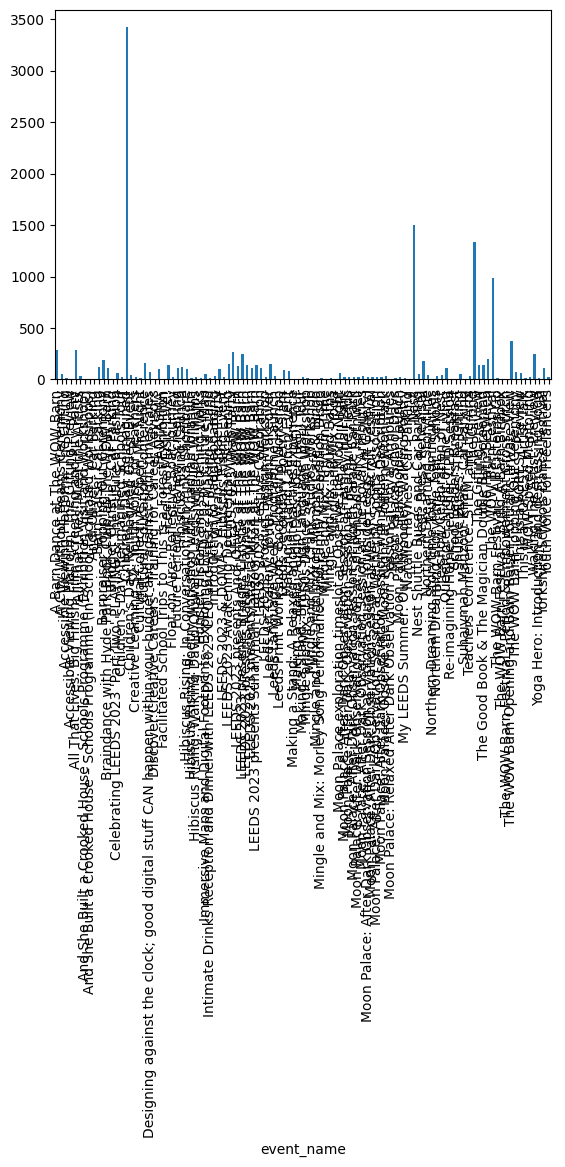

In [46]:
chart = completed_orders.groupby(['event_name']).number_of_tickets.sum().plot.bar()

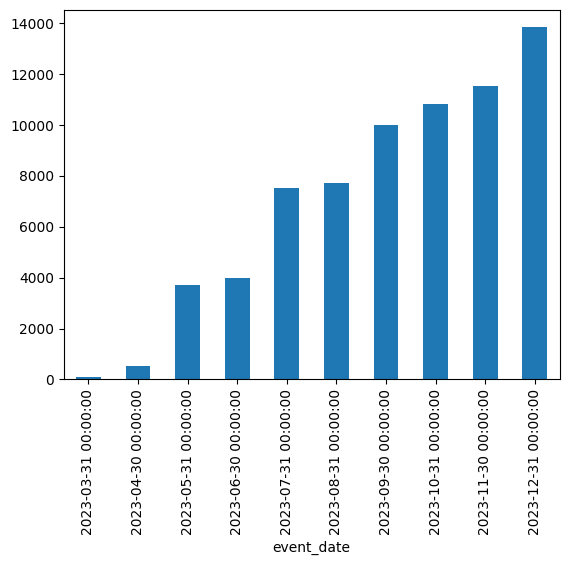

In [47]:
chart = completed_orders.groupby(['event_date']).number_of_tickets.sum().resample('M').sum().cumsum().plot.bar()


In [48]:
(
    completed_orders.loc[:, ['event_date', 'event_time', 'event_name', 'event_id', 'project_name', 'public_event']]
      .drop_duplicates()
      .sort_values(['event_date', 'event_time'])
      .to_csv('../../../../data/metrics/events/tickets/events.csv', index=False)
)